In [2]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy
import pyarrow.feather as feather


In [3]:
model_data1 = feather.read_feather('Model_data_Par1')

In [4]:
model_data1

,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp,A,...,1_X_disp1_max,1_Y_disp1_avg,1_Y_disp1_min,1_Y_disp1_max,1_Z_disp1_avg,1_Z_disp1_min,1_Z_disp1_max,1_X_disp2_avg,1_Y_disp2_avg,1_Z_disp2_avg
0,0.024484,0.422511,0.052650,1.000000,0.062210,0.043313,0.039779,0.046201,0.019263,0.016141,...,0.056,-0.00285,-0.071,0.141,-0.00318,-0.033,0.027,-0.002585,0.080270,0.000925
1,0.023526,0.419201,0.051463,1.000000,0.062263,0.042093,0.039644,0.045528,0.019323,0.016430,...,0.056,-0.00410,-0.071,0.141,-0.00308,-0.033,0.027,-0.002345,0.079370,0.000930
2,0.023526,0.419201,0.051463,1.000000,0.062263,0.042093,0.039644,0.045528,0.019323,0.016430,...,0.056,-0.00537,-0.071,0.141,-0.00310,-0.033,0.027,-0.002105,0.078505,0.001070
3,0.022984,0.418330,0.048385,1.000000,0.061038,0.040937,0.037992,0.044746,0.018641,0.014605,...,0.056,-0.00686,-0.071,0.141,-0.00313,-0.033,0.027,-0.001880,0.077460,0.000925
4,0.023336,0.422347,0.047611,1.000000,0.058869,0.041117,0.037629,0.046148,0.018517,0.015772,...,0.056,-0.00869,-0.071,0.141,-0.00333,-0.033,0.027,-0.001765,0.076435,0.000935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17097,0.551258,0.239016,0.590822,0.848327,0.556109,0.694828,1.000000,0.846755,0.592610,0.795401,...,0.031,0.07796,-0.069,0.182,-0.00022,-0.022,0.031,-0.004595,-0.008445,0.000820
17098,0.486828,0.255034,0.616595,0.832311,0.567619,0.685870,1.000000,0.849619,0.508727,0.755731,...,0.031,0.08015,-0.069,0.182,-0.00016,-0.022,0.031,-0.004820,-0.006845,0.000890
17099,0.418250,0.280371,0.653649,0.814706,0.601733,0.692381,1.000000,0.866687,0.420425,0.728755,...,0.031,0.08262,-0.051,0.182,-0.00004,-0.022,0.031,-0.005000,-0.005155,0.000960
17100,0.418250,0.280371,0.653649,0.814706,0.601733,0.692381,1.000000,0.866687,0.420425,0.728755,...,0.031,0.08466,-0.033,0.182,0.00006,-0.022,0.031,-0.005130,-0.003630,0.001030


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [6]:
tscv = TimeSeriesSplit()

In [7]:
X = model_data1.drop(columns=['1_X_disp2_avg', '1_Y_disp2_avg', '1_Z_disp2_avg']).to_numpy()
y = model_data1[['1_X_disp2_avg', '1_Y_disp2_avg', '1_Z_disp2_avg']].sum(axis=1).to_numpy()

In [91]:
X.shape

(17102, 165)

In [83]:
predictions = pd.DataFrame()
scores = pd.DataFrame()

In [85]:
def train_test(model, algo):
    count=1
    scoretemp = {algo+'_R2': [],algo+'_MAE':[], algo+'_MSE':[], algo+'_MAPE':[]}
    predictiontemp = pd.DataFrame()
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictiontemp[algo + '_y_pred' + str(count)] = y_pred
        scoretemp[algo + '_R2'].append(r2_score(y_test, y_pred))
        scoretemp[algo + '_MAE'].append(mean_absolute_error(y_test, y_pred))
        scoretemp[algo + '_MSE'].append(mean_squared_error(y_test, y_pred))
        scoretemp[algo + '_MAPE'].append(mean_absolute_error(y_test, y_pred))
        count+=1
    scoretemp = pd.DataFrame(scoretemp)
    return scoretemp, predictiontemp

In [86]:
lin = LinearRegression()
scoretemp, predictiontemp = train_test(lin, 'LR')
scores = pd.concat([scores, scoretemp], axis=1)
predictions = pd.concat([predictions, predictiontemp], axis=1)

In [87]:
dummy = DummyRegressor('mean')
scoretemp, predictiontemp = train_test(dummy, 'D')
scores = pd.concat([scores, scoretemp], axis=1)
predictions = pd.concat([predictions, predictiontemp], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass strategy=mean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [88]:
dt = DecisionTreeRegressor()
scoretemp, predictiontemp = train_test(dt, 'DT')
scores = pd.concat([scores, scoretemp], axis=1)
predictions = pd.concat([predictions, predictiontemp], axis=1)

In [14]:
rf = RandomForestRegressor(n_estimators=100)
scoretemp, predictiontemp = train_test(rf, 'RF')
scores = pd.concat([scores, scoretemp], axis=1)
predictions = pd.concat([predictions, predictiontemp], axis=1)

In [89]:
svr = SVR()
scoretemp, predictiontemp = train_test(svr, 'SVR')
scores = pd.concat([scores, scoretemp], axis=1)
predictions = pd.concat([predictions, predictiontemp], axis=1)

In [90]:
scores.describe()

,LR_R2,LR_MAE,LR_MSE,LR_MAPE,D_R2,D_MAE,D_MSE,D_MAPE,DT_R2,DT_MAE,DT_MSE,DT_MAPE,SVR_R2,SVR_MAE,SVR_MSE,SVR_MAPE
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-195.242411,0.200428,0.182897,0.200428,-0.029797,0.035172,0.002024,0.035172,-0.321864,0.038459,0.002218,0.038459,-0.033024,0.035261,0.002084,0.035261
std,431.945531,0.306102,0.393733,0.306102,0.037446,0.008736,0.001083,0.008736,0.467808,0.003084,0.000357,0.003084,0.100306,0.010420,0.001288,0.010420
min,-967.923838,0.037097,0.001989,0.037097,-0.093274,0.025149,0.000924,0.025149,-0.809556,0.033534,0.001657,0.033534,-0.150424,0.025491,0.000969,0.025491
25%,-4.717806,0.051034,0.003891,0.051034,-0.033834,0.032307,0.001431,0.032307,-0.645104,0.038278,0.002093,0.038278,-0.058644,0.029792,0.001238,0.029792
50%,-2.524947,0.073504,0.008729,0.073504,-0.010685,0.032748,0.001669,0.032748,-0.478440,0.039103,0.002325,0.039103,-0.057484,0.030999,0.001563,0.030999
75%,-0.640613,0.093877,0.012686,0.093877,-0.009249,0.036762,0.002376,0.036762,0.019594,0.039388,0.002504,0.039388,-0.024061,0.037916,0.002508,0.037916
max,-0.404853,0.746629,0.887188,0.746629,-0.001945,0.048892,0.003721,0.048892,0.304187,0.041991,0.002512,0.041991,0.125492,0.052106,0.004140,0.052106


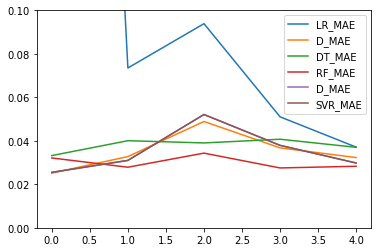

In [38]:
scores.loc[:,scores.columns.str.contains('MAE')].plot()
plt.ylim(0,.1)
plt.show()

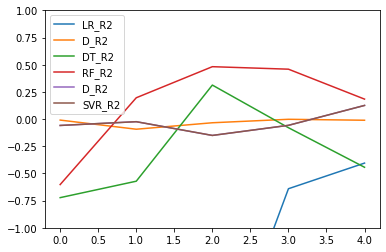

In [39]:
scores.loc[:,scores.columns.str.contains('R2')].plot()
plt.ylim(-1,1)
plt.show()

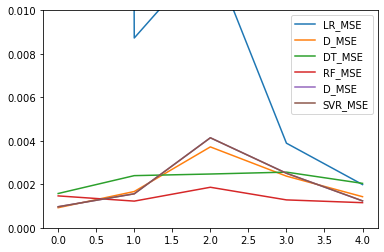

In [40]:
scores.loc[:,scores.columns.str.contains('MSE')].plot()
plt.ylim(0,0.01)
plt.show()

In [18]:
predictions

,LR_y_pred1,LR_y_pred2,LR_y_pred3,LR_y_pred4,LR_y_pred5,D_y_pred1,D_y_pred2,D_y_pred3,D_y_pred4,D_y_pred5,...,RF_y_pred1,RF_y_pred2,RF_y_pred3,RF_y_pred4,RF_y_pred5,D_y_pred1,D_y_pred2,D_y_pred3,D_y_pred4,D_y_pred5
0,-0.020297,0.046639,-0.054784,-0.031244,-0.014802,0.00091,-0.000545,0.003432,0.000674,0.000244,...,-0.021694,0.030117,-0.043304,-0.008917,0.018052,0.005327,0.005327,0.016121,0.013056,-0.006114
1,-0.017944,0.049580,-0.054967,-0.031801,-0.016719,0.00091,-0.000545,0.003432,0.000674,0.000244,...,-0.021916,0.030174,-0.041335,-0.009278,0.017991,0.005327,0.005327,0.016153,0.012517,-0.005911
2,-0.015084,0.051171,-0.055333,-0.031457,-0.017863,0.00091,-0.000545,0.003432,0.000674,0.000244,...,-0.021856,0.029452,-0.040779,-0.009323,0.017957,0.005327,0.005327,0.016100,0.012761,-0.005666
3,-0.012255,0.051034,-0.055394,-0.034654,-0.019180,0.00091,-0.000545,0.003432,0.000674,0.000244,...,-0.021820,0.029108,-0.040825,-0.009521,0.018384,0.005327,0.005327,0.016071,0.013525,-0.006651
4,-0.009741,0.046422,-0.058431,-0.039789,-0.020357,0.00091,-0.000545,0.003432,0.000674,0.000244,...,-0.021876,0.029869,-0.046477,-0.009543,0.017871,0.005327,0.005327,0.016057,0.012001,-0.007034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,0.458704,0.027116,0.097895,-0.010818,0.031174,0.00091,-0.000545,0.003432,0.000674,0.000244,...,0.021470,-0.032316,-0.019800,0.001089,0.036505,0.005327,0.005327,0.015199,-0.009675,-0.004024
2846,0.457956,0.025315,0.080775,-0.012027,0.033082,0.00091,-0.000545,0.003432,0.000674,0.000244,...,0.019260,-0.032316,-0.018501,0.001077,0.048119,0.005327,0.005327,0.015194,-0.009703,-0.003763
2847,0.460489,0.018449,0.078807,-0.014196,0.037850,0.00091,-0.000545,0.003432,0.000674,0.000244,...,0.018200,-0.036739,-0.018455,0.001077,0.048308,0.005327,0.005327,0.015192,-0.009202,-0.002565
2848,0.464941,0.009639,0.077845,-0.014632,0.039867,0.00091,-0.000545,0.003432,0.000674,0.000244,...,0.019180,-0.037373,-0.017993,0.001057,0.048120,0.005327,0.005327,0.015198,-0.008737,-0.002115


In [76]:
def plot_train_test(algo, pred=predictions, y_true=y):
    fig, ax = plt.subplots(2, 3, figsize=(20, 16))
    
    ax[0,0].set_title('1st Train Set')
    ax[0,0].set_xlabel('Time (hs)')
    ax[0,0].set_ylabel('Sum of Motion')
    ax[0,0].plot(predictions[algo + '_y_pred1'], c='red', label='Prediction')
    ax[0,0].plot(y[2851:5701], c='blue', label='Actual')
    ax[0,0].legend()

    ax[0,1].set_title('2nd Train Set')
    ax[0,1].set_xlabel('Time (hs)')
    ax[0,1].set_ylabel('Sum of Motion')
    ax[0,1].plot(predictions[algo + '_y_pred2'], c='red', label='Prediction')
    ax[0,1].plot(y[5702:8551], c='blue', label='Actual')
    ax[0,1].legend()

    ax[0,2].set_title('2nd Train Set')
    ax[0,2].set_xlabel('Time (hs)')
    ax[0,2].set_ylabel('Sum of Motion')
    ax[0,2].plot(predictions[algo + '_y_pred2'], c='red', label='Prediction')
    ax[0,2].plot(y[8552:11401], c='blue', label='Actual')
    ax[0,2].legend()

    ax[1,0].set_title('2nd Train Set')
    ax[1,0].set_xlabel('Time (hs)')
    ax[1,0].set_ylabel('Sum of Motion')
    ax[1,0].plot(predictions[algo + '_y_pred2'], c='red', label='Prediction')
    ax[1,0].plot(y[11401:14251], c='blue', label='Actual')
    ax[1,0].legend()

    ax[1,1].set_title('2nd Train Set')
    ax[1,1].set_xlabel('Time (hs)')
    ax[1,1].set_ylabel('Sum of Motion')
    ax[1,1].plot(predictions[algo + '_y_pred2'], c='red', label='Prediction')
    ax[1,1].plot(y[14251:17101], c='blue', label='Actual')
    ax[1,1].legend()
    
    plt.show()

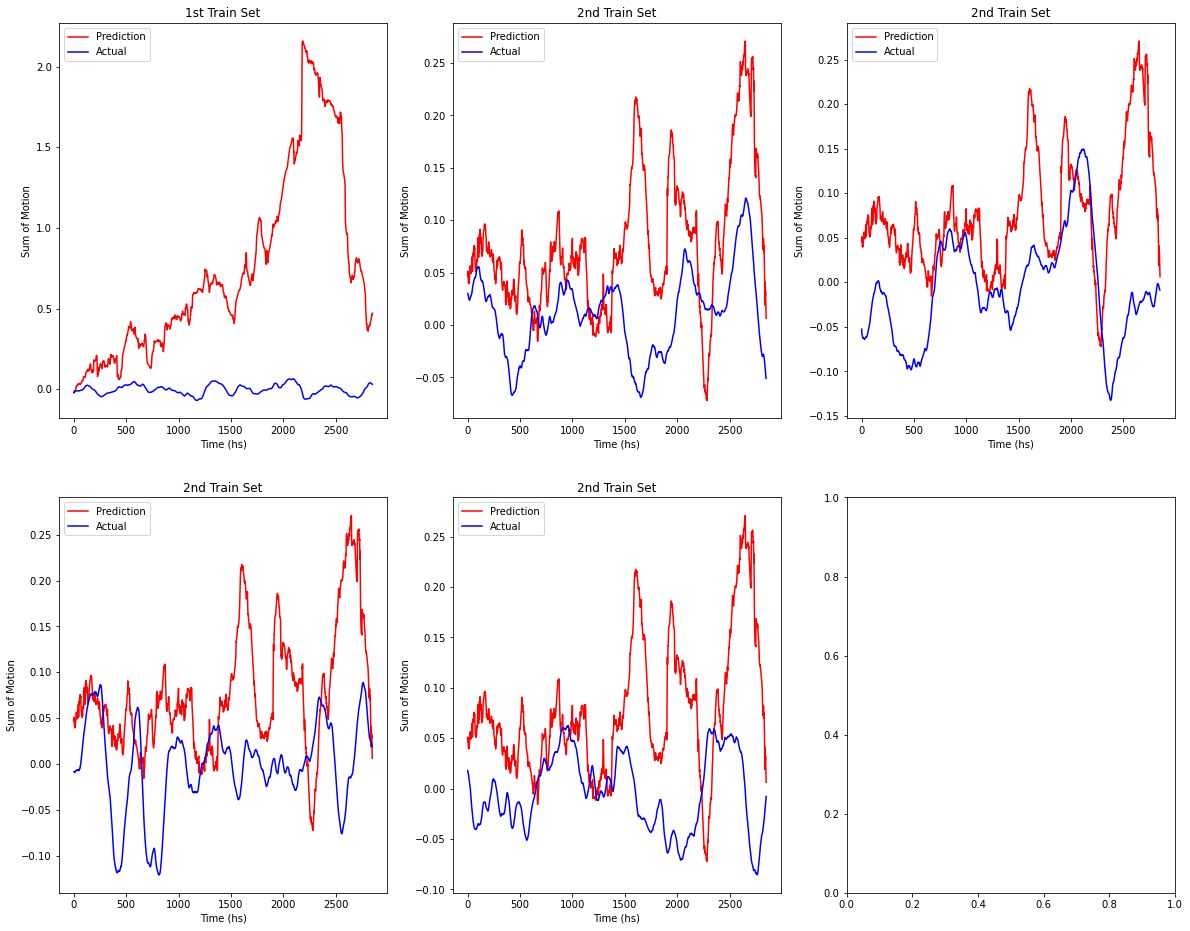

In [77]:
plot_train_test('LR')

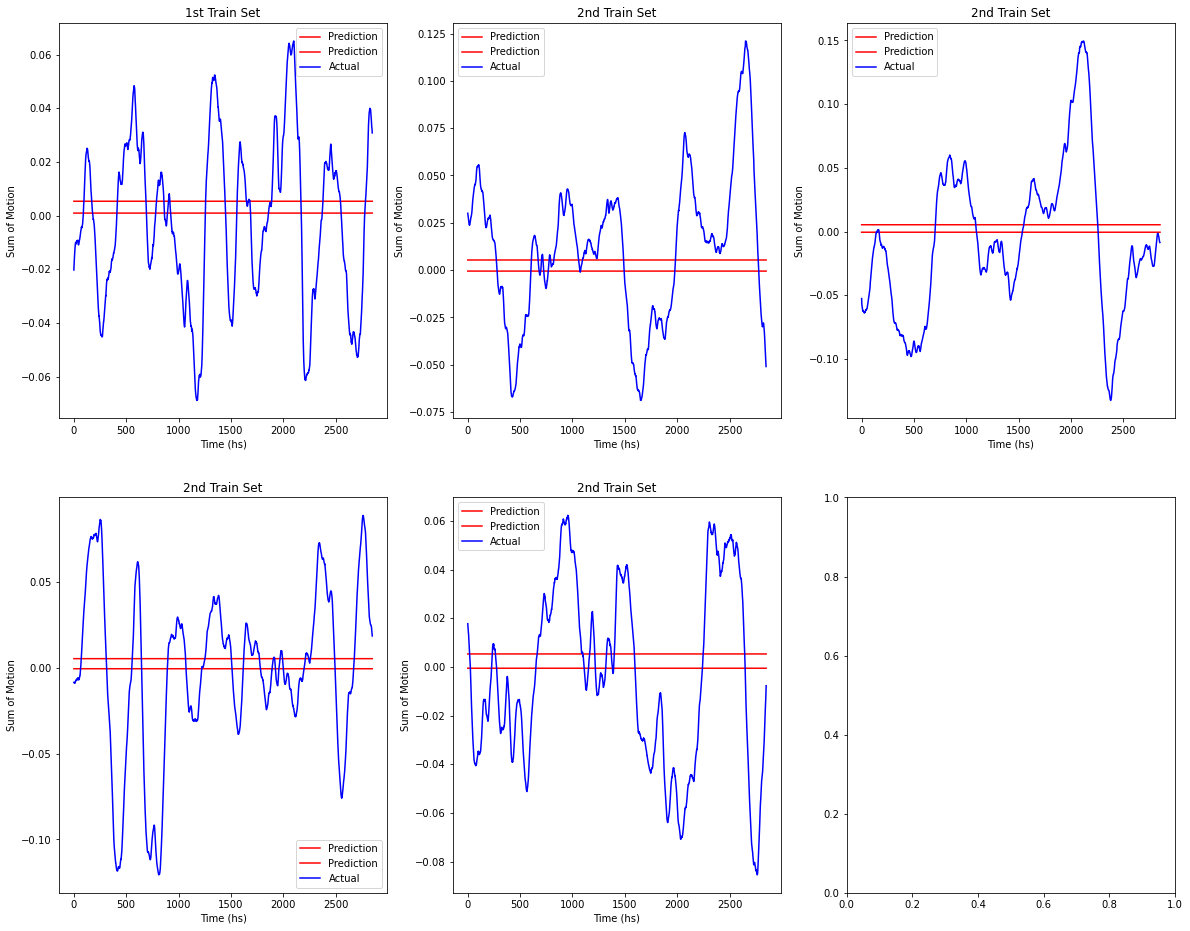

In [78]:
plot_train_test('D')

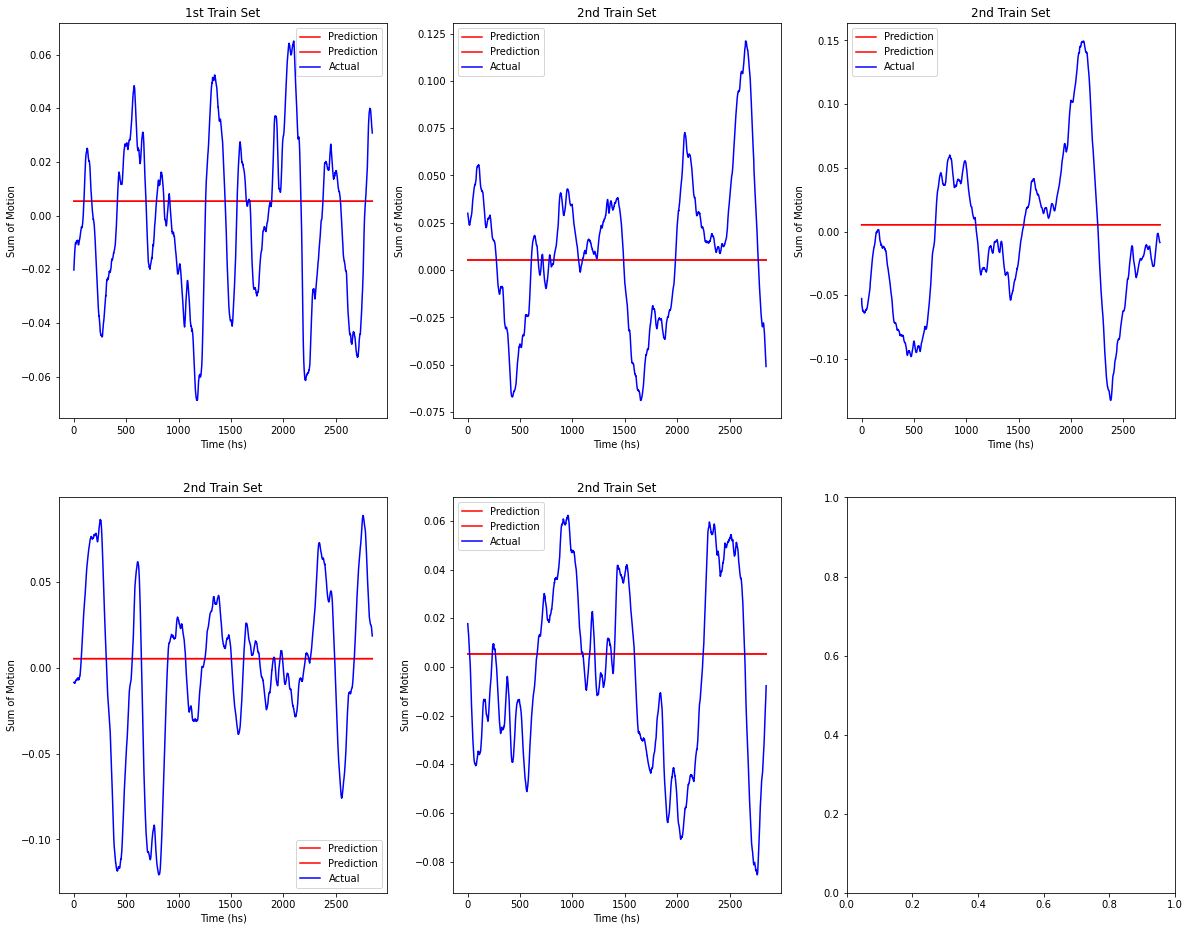

In [79]:
plot_train_test('SVR')

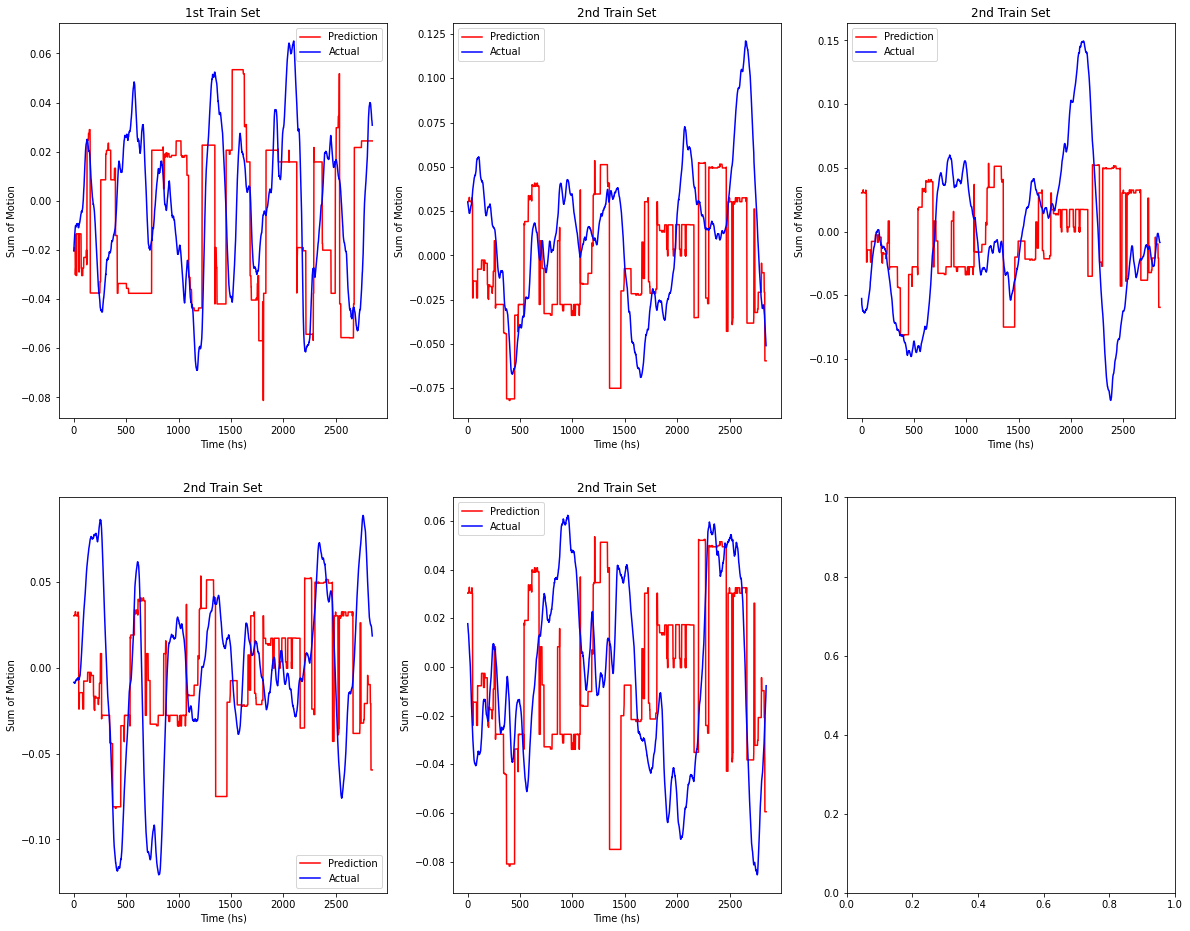

In [80]:
plot_train_test('DT')

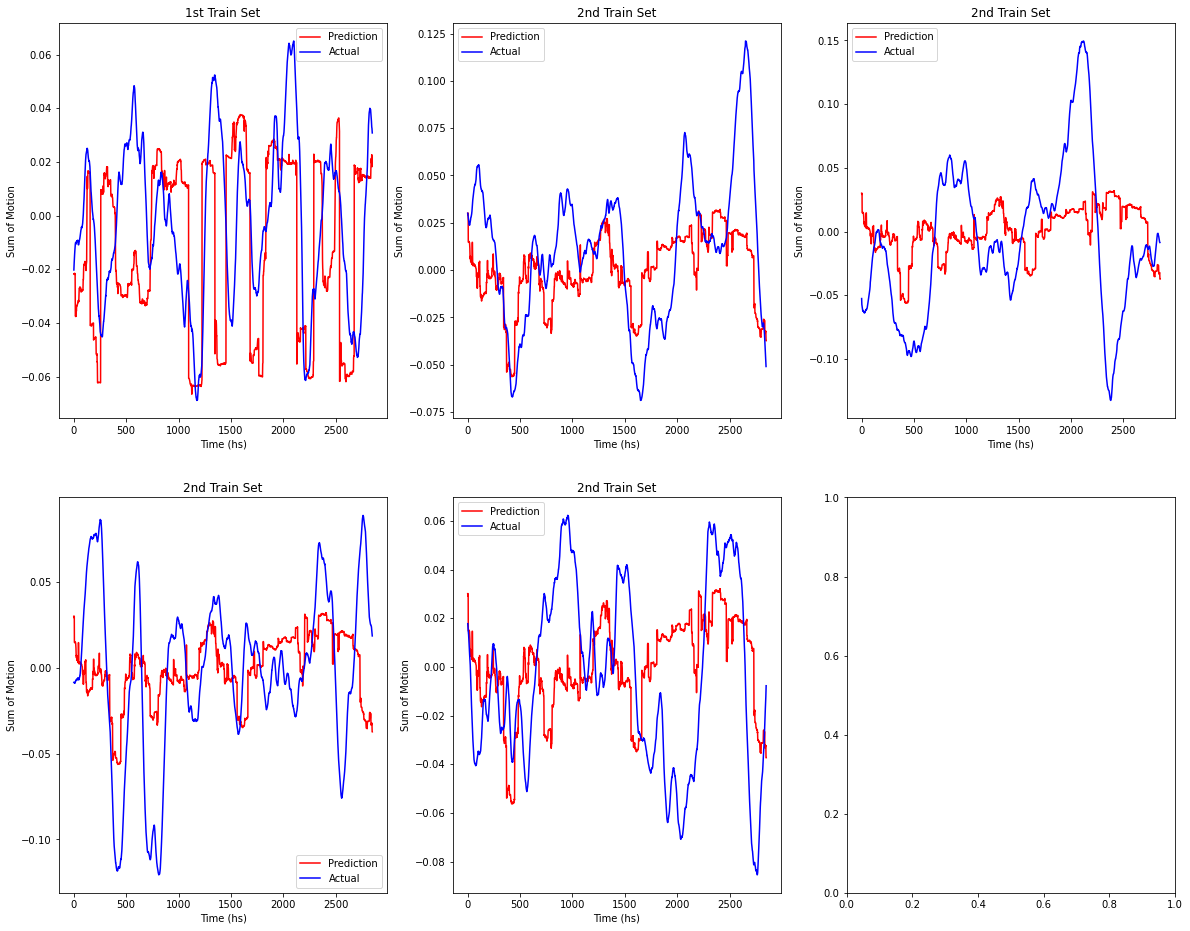

In [81]:
plot_train_test('RF')